In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import io, color
from skimage.transform import resize
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

from PIL import Image
%matplotlib inline

# Get the directory path
train_directory_path = "/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/train_ims"
test_directory_path = "/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/test_ims"

# List filenames in alphabetical order
train_filenames = sorted(os.listdir(train_directory_path))
test_filenames  = sorted(os.listdir(test_directory_path))

In [2]:
train_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/train.csv") #change path
test_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/test.csv") #change path

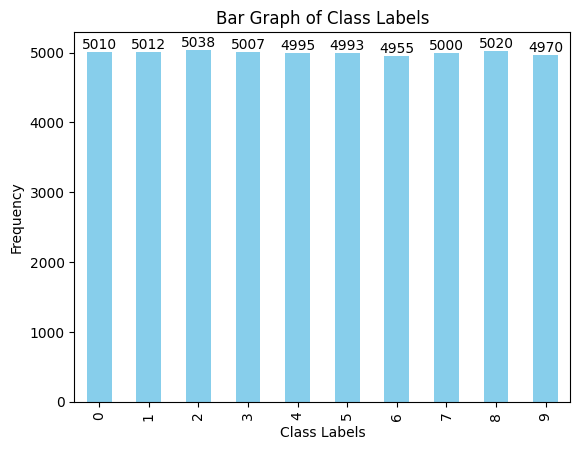

In [26]:
import matplotlib.pyplot as plt

all_labels = pd.Series(range(10))  # Creates a series from 0 to 9

# Count the occurrences of each class label and reindex with all possible labels
class_counts = train_df['label'].value_counts().reindex(all_labels, fill_value=0)

# Plotting
ax = class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Bar Graph of Class Labels')


# Adding text labels on each bar
for p in ax.patches:
    # Only annotate non-zero bars
    if p.get_height() > 0:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5),  # Reduced y offset to bring text lower
                    textcoords='offset points')

plt.show()


In [30]:
print(train_df.describe())

              label
count  50000.000000
mean       4.493480
std        2.872776
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max        9.000000


In [22]:
aug = iaa.Sequential([
    iaa.Fliplr(0.5),  # Flip horizontally with 50% probability
    iaa.Flipud(0.5),  # Flip vertically with 50% probability
    iaa.Affine(rotate=(-10, 10)),  # Randomly rotate the image by up to 10 degrees
    iaa.GaussianBlur(sigma=(0.0, 0.2)),  # Apply Gaussian blur with a sigma between 0 and 0.5
])

In [31]:
x_train = []
x_test = []


train_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/train.csv") #change path
test_df = pd.read_csv("/Users/Admin/Documents/HKU Fintech Work/Year 2/Year 2 Sem 2/COMP3314 Machine Learning/Group Project/COMP3314-Group-Project/test.csv") #change path


for i in range(50000): #only checking first 1000 images
    image = io.imread(f"{train_directory_path}/{train_filenames[i]}")
    x_train.append(image)

    '''if i < 40000:
        x_train.append(image)
    else:
        x_test.append(image)


        '''

ratio_a= 10000
ratio_b= 20000
    
augmented_images = aug(images=x_train[ratio_a:ratio_b])

x_train = np.array(x_train)
x_train = np.concatenate((x_train, augmented_images))


y_train = np.array(train_df["label"].to_numpy())
y_train = np.concatenate((y_train, y_train[ratio_a:ratio_b]))

y_test = np.array(test_df["label"].to_numpy())

assert x_train.shape == (50000+(ratio_b-ratio_a), 32, 32, 3)


y_train = y_train.reshape(-1)

assert y_train.shape == (50000+(ratio_b-ratio_a),)


In [32]:
def get_sift_feature(im):
    gray_im = color.rgb2gray(im)
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute((gray_im * 255).astype("uint8"), None)
    if descriptors is None:
        return np.zeros((128,))
    return np.mean(descriptors, axis=0) 

def get_hog_feature(im):
    gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) / 255
    hog_features = hog(gray_im, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

    hsv_image = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    
    hist_features = []
    for channel in cv2.split(hsv_image):
        hist_features.append(cv2.calcHist([channel], [0], None, [8], [0, 256]))

    hist_features = np.concatenate(hist_features).flatten() / (image.shape[0] * image.shape[1])

    merged_features = np.concatenate((hog_features, hist_features))
    return(merged_features)


def sift_hog_combined_features(im):
    hog_features = get_hog_feature(im)
    sift_features = get_sift_feature(im)
    combined_features = np.concatenate((hog_features, sift_features))
    return combined_features

In [33]:
sift_hog_features_train = []

for image1 in x_train:
    sift_hog_features_train.append(sift_hog_combined_features(image1)) #checking for sift feature 

sift_hog_features_train = np.array(sift_hog_features_train)

In [35]:
print(sift_hog_features_train.shape)

(60000, 476)


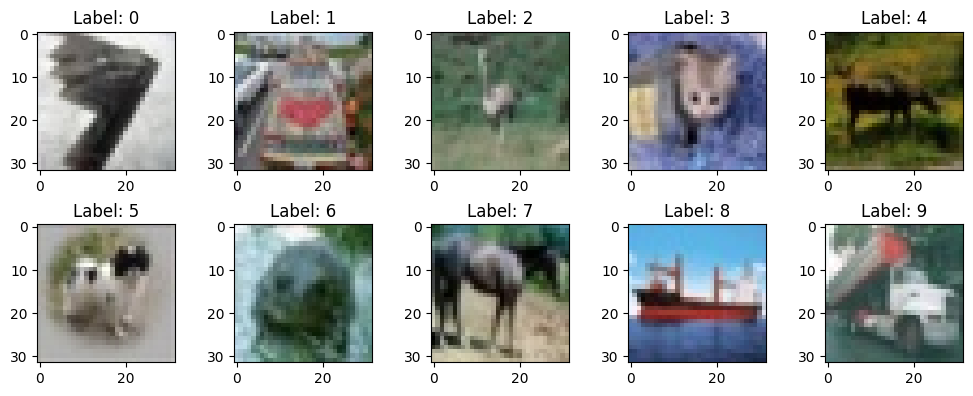

In [39]:

unique_labels = np.unique(y_train)

# Set up the plot - calculate number of rows and columns
num_labels = len(unique_labels)
cols = 5  
rows = (num_labels + cols - 1) // cols  

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))  # Adjust size as needed
axes = axes.flatten()

for i, label in enumerate(unique_labels):
    # Find the first image for the current label
    index = np.where(y_train == label)[0][0]
    axes[i].imshow(x_train[index])
    axes[i].set_title(f'Label: {label}')
    #axes[i].axis('off')

# Turn off axes for any unused subplots
for ax in axes[num_labels:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

ValueError: cannot reshape array of size 476 into shape (2,2,9)

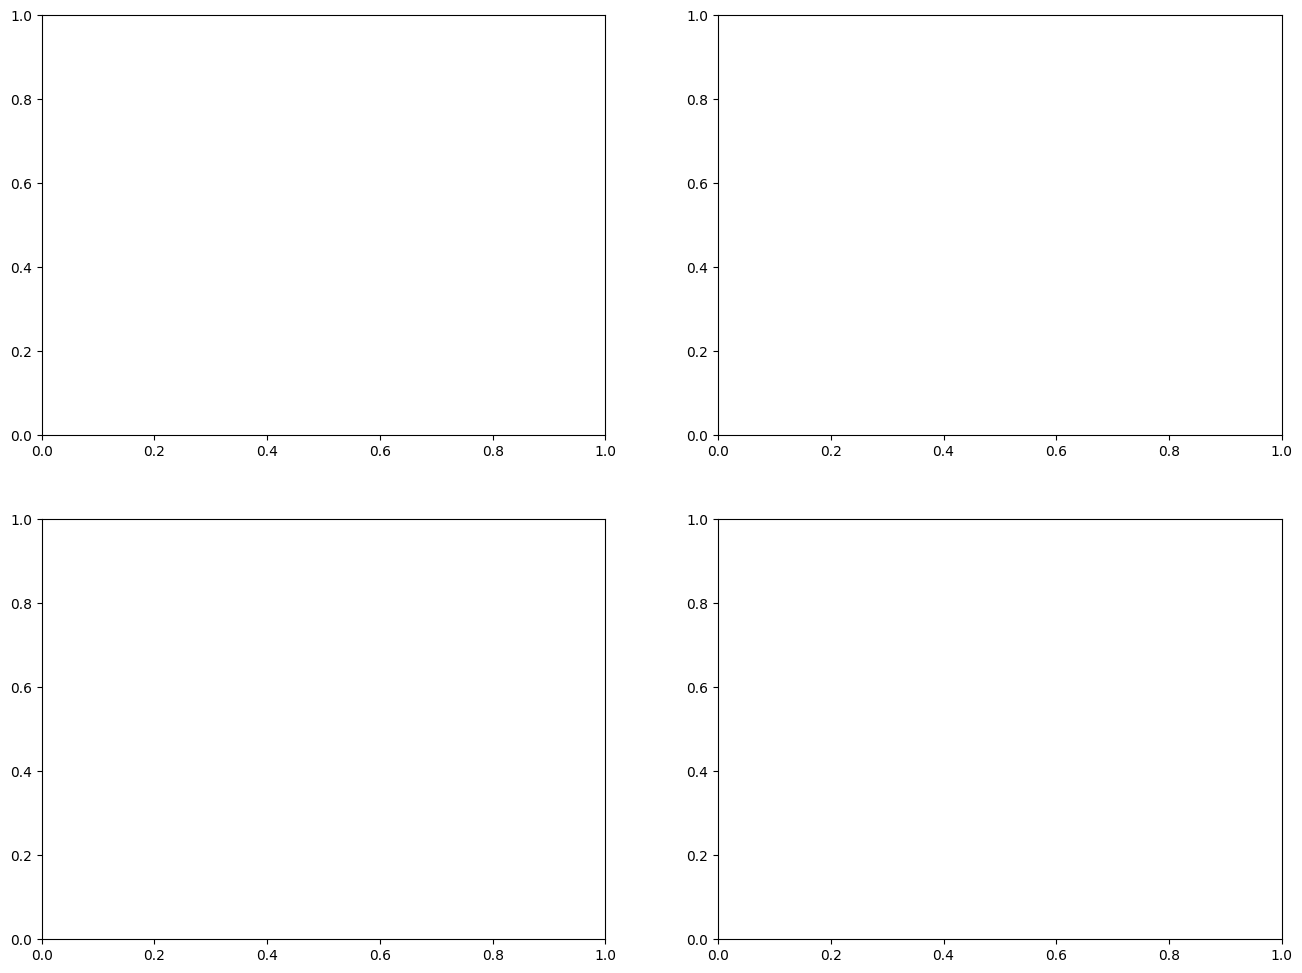

In [37]:
def plot_hog_features(hog_features, orientations, pixels_per_cell, cells_per_image, image_shape):
    cell_width, cell_height = pixels_per_cell
    cells_x, cells_y = cells_per_image

    # Define a grid for subplotting
    fig, axes = plt.subplots(cells_y, cells_x, figsize=(16, 12))
    
    # Reshape hog_features back into the original cell-wise histogram layout
    hog_reshaped = hog_features.reshape((cells_y, cells_x, orientations))

    for i in range(cells_y):
        for j in range(cells_x):
            ax = axes[i, j]
            # Create a bar plot with the histogram values for this cell
            ax.bar(x=np.arange(orientations), height=hog_reshaped[i, j], align='center')
            ax.set_xlim([0, orientations - 1])
            ax.set_ylim([0, max(1.0, np.max(hog_reshaped))])
            ax.axis('off')
    plt.show()

# Parameters
orientations = 9
pixels_per_cell = (8, 8)  # assuming each cell is 8x8 pixels
cells_per_image = (2, 2)  # assuming each image results in 7x7 cells
image_shape = (32, 32)    # assuming each image is 56x56 pixels

# Example usage with first 10 rows of your HOG feature dataset
for index in range(10):
    plot_hog_features(sift_hog_features_train[index], orientations, pixels_per_cell, cells_per_image, image_shape)